In [1]:
# ruff: noqa
import pandas as pd
from pathlib import Path
import nccdb
import nccdb.langmodel
import nccdb.langmodel.indication
from pathlib import Path
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report

db = nccdb.get_db()

◯ cache_dir: /Users/mizuy/lab/nccdb/cache
× data_dir: /Volumes/nccdb
× lossy_dir: /Volumes/nccdb_image2/target


In [ ]:
indication_manual = pd.read_excel(
    "indication_manual_500-v2.xlsx", index_col="id_proc", usecols=["id_proc", "indication_manual"]
).sort_index()
prompt = Path("../data/langmodel/indication/prompt_new2.txt").read_text()
lm_indication = pd.read_excel(
  
    # "lm_indication_latest_mxfp4.xlsx",
    "lm_indication_latest.xlsx",
     index_col="id_proc", usecols=["id_proc", "lm_indication", "lm_conf"]
).assign(lm_conf=lambda x: x.lm_conf.replace({"中": "medium", "高": "high"}))
list_indication = nccdb.langmodel.indication.indication_list

assert indication_manual.isin(list_indication).all().all()
assert lm_indication.lm_indication.isin(list_indication).all().all()
# assert lm_indication.lm_conf.isin(['high','medium','low']).all().all()
assert set(indication_manual.index) == set(lm_indication.index)
print(len(list_indication))
cat_indication = pd.CategoricalDtype(list_indication,ordered=True)

lm_indication = lm_indication.assign(
  lm_indication = lambda x: x.lm_indication.astype(cat_indication)
)
indication_manual = indication_manual.astype(cat_indication)

def train():
    target = nccdb.langmodel.indication._prepare_data(db.cs.proc)[lambda x: x.id_proc.isin(indication_manual.index)]
    return nccdb.langmodel.indication.calc_indication_no_cache(
        target, prompt, batchsize=10, logfile=Path("lm_log2.txt")
    )

18


In [3]:
ret = train()
# ret.to_excel("lm_indication_latest.xlsx")

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

2025-11-01 01:31:36.746 | INFO     | nccdb.langmodel.indication:_process_single_batch:127 - -----------
2025-11-01 01:31:36.747 | INFO     | nccdb.langmodel.indication:_process_single_batch:128 - Proc200708130041,無症状スクリーニング,low
Proc200708150048,無症状スクリーニング,high
Proc200709110007,遺伝性ポリポーシス,high
Proc200709270013,大腸癌術前検査,high
Proc200709270012,内視鏡治療前精査,medium
Proc200709280005,有症状精査(下血/血便),high
Proc200711140006,内視鏡切除,medium
Proc200711290003,内視鏡治療後サーベイランス,medium
Proc200712270006,既知病変の検査,high
Proc200801170007,原発不明がん精査,medium
2025-11-01 01:31:54.466 | INFO     | nccdb.langmodel.indication:_process_single_batch:127 - -----------
2025-11-01 01:31:54.466 | INFO     | nccdb.langmodel.indication:_process_single_batch:128 - Proc200802120006,無症状スクリーニング,high
Proc200802270034,大腸癌術後サーベイランス,medium
Proc200803030059,内視鏡治療後サーベイランス,high
Proc200803030056,内視鏡治療後サーベイランス,high
Proc200804080009,原発不明がん精査,medium
Proc200804160065,内視鏡切除,high
Proc200805070014,大腸癌術後サーベイランス,high
Proc200805130012,大腸癌術前検査,高
Proc200806160004,

In [4]:
ret.to_excel("lm_indication_latest_mxfp4.xlsx")

In [7]:
df = (
    nccdb.langmodel.indication._prepare_data(db.cs.proc)
    .assign(
        jedperiod=lambda x: x.nendo >= 2015,
        j_検査目的_notna=lambda x: x["j_検査目的"].notna(),
    )
    .merge(
        indication_manual,
        on="id_proc",
        how="left",
    )
    .merge(
        lm_indication,
        on="id_proc",
        how="left",
    )
    .f.notna("lm_indication")
    .assign(
        lm_indication=lambda x: x.lm_indication.fillna("その他不明"),
        correct=lambda x: x.lm_indication == x.indication_manual,
        j_indication=lambda x: x.j_検査目的.map(
            {
                "内視鏡治療後サーベイランス": "内視鏡治療後サーベイランス",
                "スクリーニング": "無症状スクリーニング",
                "治療前精査": "内視鏡治療前精査",
                "大腸癌術後サーベイランス": "大腸癌術後サーベイランス",
                "下血/血便以外の有症状": "有症状精査(下血/血便以外)",
                "内視鏡切除": "内視鏡切除",
                "術前点墨マーキング": "大腸癌術前検査",
                "便潜血精査": "便潜血精査",
                "大腸癌化療・放射線治療後評価": "大腸癌化療・放射線治療後評価",
                "下血/血便": "有症状精査(下血/血便)",
                "その他": "その他不明",
            }
        ).astype(cat_indication),
        j_true_indication=lambda x: x.indication_manual.map(
            {
                "遺伝性ポリポーシス": None,
                "遺伝性非ポリポーシス": None,
                "大腸癌術前検査": "術前点墨マーキング",
                "内視鏡切除": "内視鏡切除",
                "内視鏡治療前精査": "治療前精査",
                "既知病変の検査": None,
                "便潜血精査": "便潜血精査",
                "有症状精査(下血/血便)": "下血/血便",
                "有症状精査(下血/血便以外)": "下血/血便以外の有症状",
                "他検査で異常(画像検査)": None,
                "他検査で異常(血液検査)": None,
                "原発不明がん精査": None,
                "大腸癌化療・放射線治療後評価": "大腸癌化療・放射線治療後評価",
                "大腸癌術後サーベイランス": "大腸癌術後サーベイランス",
                "炎症性腸疾患サーベイランス": "炎症性腸疾患サーベイランス",
                "内視鏡治療後サーベイランス": "内視鏡治療後サーベイランス",
                "無症状スクリーニング": "スクリーニング",
                "その他不明": "その他",
            }
        ),
    )
)

df.to_excel("indication_checkme2.xlsx")


In [8]:
def metric_report(df, col_predict, col_truth):
    # データの基本情報を確認
    print(f"truth: {col_truth}, predict: {col_predict}")
    print(f"総サンプル数: {len(df)}")
    print(f"人手チェック済み: {df[col_truth].notna().sum()}")

    print(f"n of classes: {len(df[col_predict].unique())}")

    # 一致状況を確認
    df_eval = df.f.notna(col_truth).f.notna(col_predict)
    print(f"\n評価対象数: {len(df_eval)}")

    # 基本的な一致率
    correct = df_eval[col_predict] == df_eval[col_truth]
    accuracy = correct.mean()
    print(f"正解率: {correct.mean():.1%} ({correct.sum()}/{len(df_eval)})")


    # print("\n=== 予測と実際の分布 ===")
    # print("\n予測結果の分布:")
    # print(df_eval["lm_indication"].value_counts())
    # print("\n人手チェック結果の分布:")
    # print(df_eval[col_truth].value_counts())

    print("\n=== 分類レポート ===")
    report = classification_report(df_eval[col_truth], df_eval[col_predict], zero_division=0, output_dict=True)
    report = pd.DataFrame(report).transpose()
    display(report)

metric_report(df, 'lm_indication','indication_manual')
metric_report(df.f.notna('j_true_indication').f.notna('j_検査目的'), 'j_検査目的','j_true_indication')


truth: indication_manual, predict: lm_indication
総サンプル数: 500
人手チェック済み: 500
n of classes: 18

評価対象数: 500
正解率: 85.4% (427/500)

=== 分類レポート ===


,precision,recall,f1-score,support
その他不明,0.000000,0.000000,0.000000,1.000
他検査で異常(画像検査),0.833333,0.555556,0.666667,9.000
他検査で異常(血液検査),1.000000,0.333333,0.500000,6.000
便潜血精査,0.800000,1.000000,0.888889,12.000
内視鏡切除,0.897059,0.897059,0.897059,68.000
内視鏡治療前精査,0.653846,0.944444,0.772727,18.000
内視鏡治療後サーベイランス,0.875000,0.884211,0.879581,95.000
原発不明がん精査,0.571429,1.000000,0.727273,4.000
大腸癌化療・放射線治療後評価,0.928571,0.928571,0.928571,14.000
大腸癌術前検査,0.970588,0.804878,0.880000,41.000


truth: j_true_indication, predict: j_検査目的
総サンプル数: 162
人手チェック済み: 162
n of classes: 11

評価対象数: 162
正解率: 76.5% (124/162)

=== 分類レポート ===


,precision,recall,f1-score,support
その他,0.000000,0.000000,0.000000,0.000000
スクリーニング,0.625000,0.937500,0.750000,16.000000
下血/血便,1.000000,1.000000,1.000000,3.000000
下血/血便以外の有症状,1.000000,0.700000,0.823529,10.000000
便潜血精査,1.000000,0.666667,0.800000,6.000000
内視鏡切除,0.913043,0.875000,0.893617,24.000000
内視鏡治療後サーベイランス,0.967742,0.714286,0.821918,42.000000
大腸癌化療・放射線治療後評価,0.857143,0.666667,0.750000,9.000000
大腸癌術後サーベイランス,0.920000,0.884615,0.901961,26.000000
治療前精査,0.521739,0.857143,0.648649,14.000000


In [74]:
px.parallel_categories(df, dimensions=["lm_indication", "indication_manual"], width=600)

In [ ]:
px.parallel_categories(
    df.f.notna("j_true_indication").f.notna("j_検査目的"), dimensions=["j_検査目的", "j_true_indication"], width=600
)

In [20]:
df_eval = df.assign(
  jedperiod = lambda x: x.nendo>=2015,
  j_検査目的_notna = df_eval["j_検査目的"].notna(),
  mo_study_purpose_notna = df_eval["mo_study_purpose"].notna(),
  mo_study_purpose_short = df_eval["mo_study_purpose"].str.len().fillna(0) < 10,
)
print(len(df_eval))

from scipy.stats import fisher_exact

print(df_eval.groupby('lm_conf').correct.mean())
t = pd.crosstab(df_eval.lm_conf, df_eval.correct)
display(t)
print(fisher_exact(t).pvalue)

print(df_eval.groupby('jedperiod').correct.mean())
t = pd.crosstab(df_eval.jedperiod, df_eval.correct)
display(t)
print(fisher_exact(t).pvalue)


print(df_eval.groupby('j_検査目的_notna').correct.mean())
t = pd.crosstab(df_eval.j_検査目的_notna, df_eval.correct)
display(t)
print(fisher_exact(t).pvalue)

print(df_eval.groupby('mo_study_purpose_notna').correct.mean())
t = pd.crosstab(df_eval.mo_study_purpose_notna, df_eval.correct)
display(t)
print(fisher_exact(t).pvalue)

print(df_eval.groupby('mo_study_purpose_short').correct.mean())
t = pd.crosstab(df_eval.mo_study_purpose_short, df_eval.correct)
display(t)
print(fisher_exact(t).pvalue)

500
lm_conf
high      0.885650
low       0.000000
medium    0.679245
Name: correct, dtype: float64


correct,False,True
lm_conf,,
high,51,395
low,1,0
medium,17,36


0.0001
jedperiod
False    0.882653
True     0.848684
Name: correct, dtype: float64


correct,False,True
jedperiod,,
False,23,173
True,46,258


0.3525741396874436
j_検査目的_notna
False    0.877023
True     0.837696
Name: correct, dtype: float64


correct,False,True
j_検査目的_notna,,
False,38,271
True,31,160


0.23112693965761405
mo_study_purpose_notna
False    0.846154
True     0.862423
Name: correct, dtype: float64


correct,False,True
mo_study_purpose_notna,,
False,2,11
True,67,420


0.6972199096758431
mo_study_purpose_short
False    0.811594
True     0.924107
Name: correct, dtype: float64


correct,False,True
mo_study_purpose_short,,
False,52,224
True,17,207


0.0002446170690078454


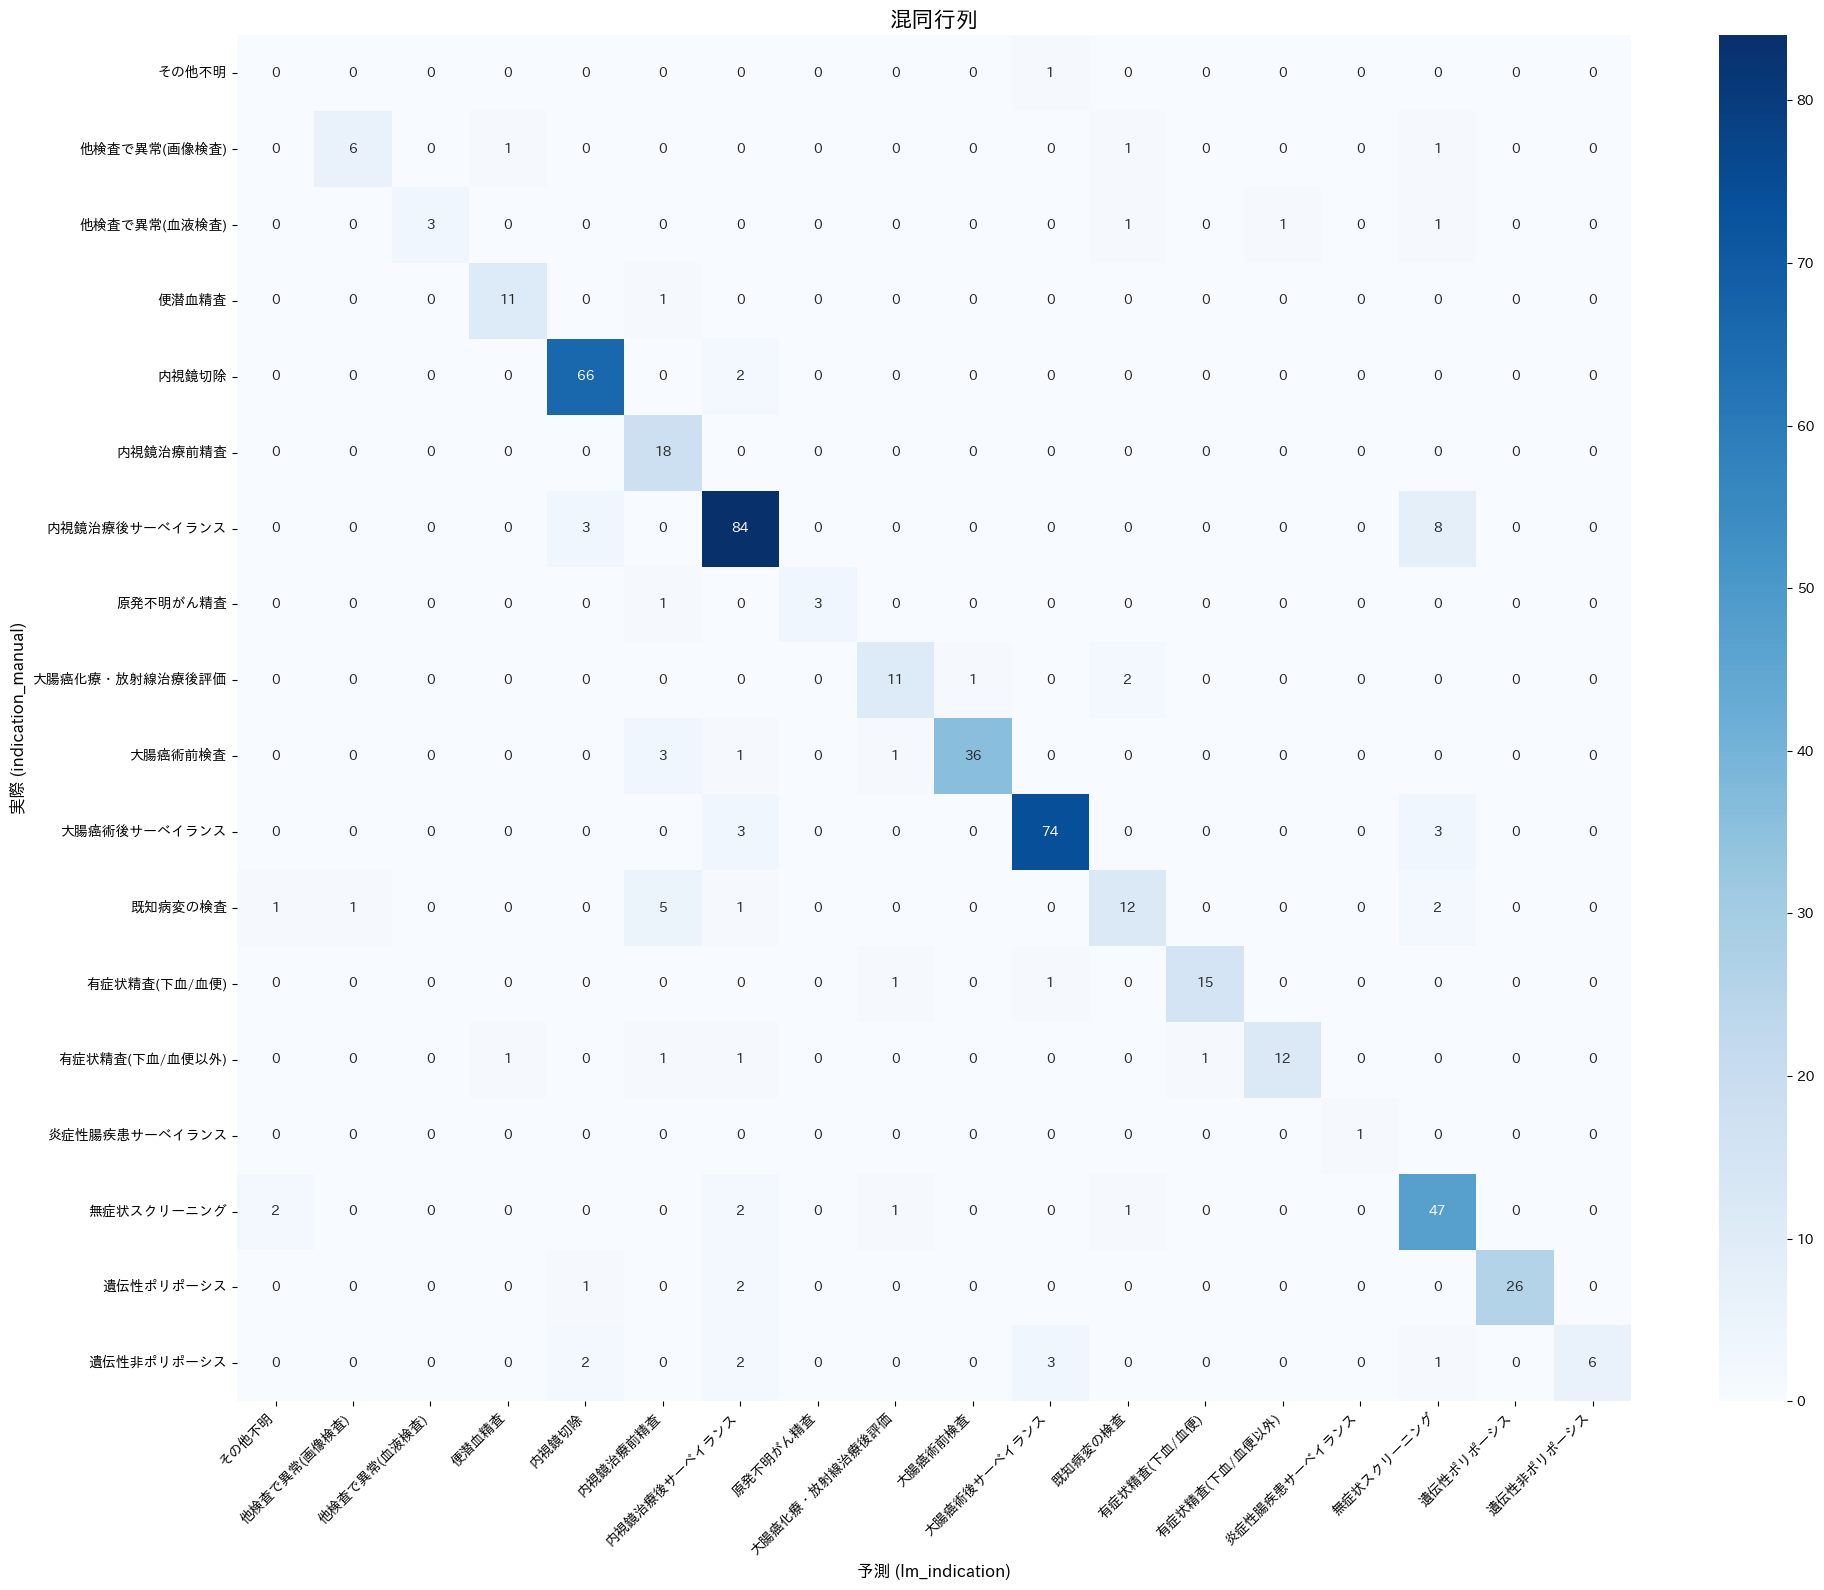

In [76]:
# 混同行列の作成と可視化
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# 混同行列を作成
df_eval = df.f.notna("indication_manual")
cm = confusion_matrix(df_eval['indication_manual'], df_eval['lm_indication'])

# 可視化
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(df_eval['lm_indication'].unique()),
            yticklabels=sorted(df_eval['indication_manual'].unique()))
plt.xlabel('予測 (lm_indication)', fontsize=12)
plt.ylabel('実際 (indication_manual)', fontsize=12)
plt.title('混同行列', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
print(report.to_markdown())

医療DXが切り拓く消化器内視鏡の未来
The Future of Gastrointestinal Endoscopy: Paved by Medical DX（Digital Transformation）


Digital Transformation (以下DX)は分散されたデータの有機的な連携を行うことで業務やデータ管理、統計処理を効率的に行うという方法論であり、これは医療分野にも適応されつつある。さらに消化器内視鏡診療関連のデータは医師の記載する内視鏡検査の報告書として記載するものにとどまらず、切っても切り離さない構成要素である病理関連情報、放射線関連情報と多岐にわたる。加えて診療時に使用する薬剤の情報や医療材料の情報、バイタルサイン、看護記録など重要な情報も存在する。これらの連携によってさまざまな利益が生ずると思われる。本セッションでは施設で取り組まれているDXの実際をご提示いただき、現状存在する問題点とともに今後の展開を議論していきたい。多くの事例をご提示いただき、実りのある議論を目指したい。

## Title
Local 大規模言語モデルを使用した大腸内視鏡における検査適応の推定

## Background

- 大腸内視鏡検査において検査目的や患者背景情報は臨床解析上極めて重要である
- JED導入により、advancedな解析ができるようになった。しかし、誤入力や、JED導入以前の検査目的が解析できない問題がある
- これに対して、従来は人力による入力補完や、ルールベースの自然言語処理により検査目的を推定した報告はある。
- 近年、Local大規模言語モデル（Local LLM）は、個人情報を外部に送信せずに解析できる新技術として注目されている。

## Methods
2007年8月から2025年10月までの大腸内視鏡検査70,225例を対象とした。データベースから以下を抽出：
- JEDの検査目的 (2015年以降のみ存在)
- 依頼医師の内視鏡オーダー時の検査目的についてのコメント（日本語）
- 依頼医師のコメント
- 内視鏡DBから算出した大腸手術歴、大腸内視鏡治療歴, ポリポーシス/遺伝性腫瘍の有無
- 内視鏡レポートに記載のコメント

これらをLocal LLM（LM Studio）に入力し、prompt（data/langmodel/indication/prompt_step4.txt）に基づき検査適応を推定した。検査適応はJEDの検査適応の項目をすこし詳細化した、13のカテゴリーとした。300例をランダム抽出し、人手チェック（indication_manual）をgold standardとして設定。300例のtest setでLLM精度を検証した。

## Results
- 総サンプル数：69,588例
- 人手チェック実施数：300例
- **全体精度：90.7%**

抄録に盛り込むべきデータは
- 全体における、macro avb, weighted avgのprecision, recall, f1-score
- 内視鏡治療後サーベイランス、スクリーニング、大腸術後サーベイランスの成績f1-score

|                              |   precision |   recall |   f1-score |    support |
|:-----------------------------|------------:|---------:|-----------:|-----------:|
| ポリープ経過観察             |    0.769231 | 0.769231 |   0.769231 |  13        |
| 不明                         |    0.428571 | 0.428571 |   0.428571 |   7        |
| 他検査で異常(画像検査)       |    0.555556 | 0.714286 |   0.625    |   7        |
| 他検査で異常(血液検査)       |    0.666667 | 1        |   0.8      |   2        |
| 便潜血精査                   |    0.875    | 1        |   0.933333 |   7        |
| 内視鏡切除                   |    0.97619  | 0.931818 |   0.953488 |  44        |
| 内視鏡治療前精査             |    1        | 0.933333 |   0.965517 |  15        |
| 内視鏡治療後サーベイランス   |    0.910448 | 0.938462 |   0.924242 |  65        |
| 原発不明がん精査             |    1        | 1        |   1        |   3        |
| 大腸癌化療・放射線治療後評価 |    1        | 0.9      |   0.947368 |  10        |
| 大腸癌術前検査               |    0.947368 | 0.857143 |   0.9      |  21        |
| 大腸癌術後サーベイランス     |    1        | 0.976744 |   0.988235 |  43        |
| 有症状精査(下血/血便)        |    1        | 0.916667 |   0.956522 |  12        |
| 有症状精査(下血/血便以外)    |    0.666667 | 0.666667 |   0.666667 |   6        |
| 炎症性腸疾患サーベイランス   |    0        | 0        |   0        |   0        |
| 無症状スクリーニング         |    0.928571 | 0.896552 |   0.912281 |  29        |
| 遺伝性ポリポーシス           |    0.875    | 1        |   0.933333 |  14        |
| 非遺伝性ポリポーシス         |    1        | 1        |   1        |   2        |
| accuracy                     |    0.906667 | 0.906667 |   0.906667 |   0.906667 |
| macro avg                    |    0.811071 | 0.829415 |   0.816877 | 300        |
| weighted avg                 |    0.915173 | 0.906667 |   0.909631 | 300        |

## Conclusions
Local LLMによる検査適応の自動推定は高精度であり、既存データの入力漏れ補完やデータベース品質向上に有用であった。今後はさらなる大規模検証とprompt最適化により、院内自動注釈支援システムとしての実装が期待される。

In [ ]:
proc = invoke.load()
df = proc.f.notna("lm_indication")[
    [
        "j_検査目的",
        "mo_study_purpose",
        "m_special_instruct",
        "hx_surgery",
        "hx_er",
        "e_comment",
        "is_hcs",
        "lm_indication",
    ]
].merge(
    pd.read_excel("indication_manual.xlsx", index_col="id_proc", usecols=["id_proc", "indication_manual"]),
    on="id_proc",
    how="left",
)

In [ ]:
# df = nccdb.NccdbProc(pd.read_excel("indication_manual.xlsx", index_col="id_proc", usecols=["id_proc", "indication_manual"]))
# df = df.merge(
#     proc[
#         [
#             "date",
#             "j_検査目的",
#             "mo_study_purpose",
#             "m_special_instruct",
#             "hx_surgery",
#             "hx_er",
#             "e_comment",
#             "is_hcs",
#             # "lm_indication",
#         ]
#     ],
#     on="id_proc",
#     how="left",
# )
# prompt = Path('data/langmodel/indication/prompt_step100.txt').read_text()
# ret = nccdb.langmodel.indication.calc_indication_no_cache(df, prompt, batchsize=3)
# ret.to_excel("lm_indication_new2.xlsx")
# ret.lm_indication.pp.vc()

In [ ]:
ret.lm_indication.pp.vc()